scaping data tweet 
max api 0

In [56]:
import pandas as pd

# Baca kedua file
df1 = pd.read_csv("dataset.csv")
df2 = pd.read_csv("dataset1.csv")

# Gabungkan vertikal
combined_df = pd.concat([df1, df2], ignore_index=True)

# Simpan hasil
combined_df.to_csv("gabungan.csv", index=False)

Membaca dataset...
Membersihkan teks...


100%|██████████| 893/893 [00:00<00:00, 21288.95it/s]


Memuat stopwords...
Melakukan normalisasi teks...


100%|██████████| 893/893 [04:11<00:00,  3.55it/s]


Melakukan analisis sentimen...
Menganalisis sentimen...


100%|██████████| 893/893 [00:06<00:00, 135.92it/s]


Membuat visualisasi sentimen...


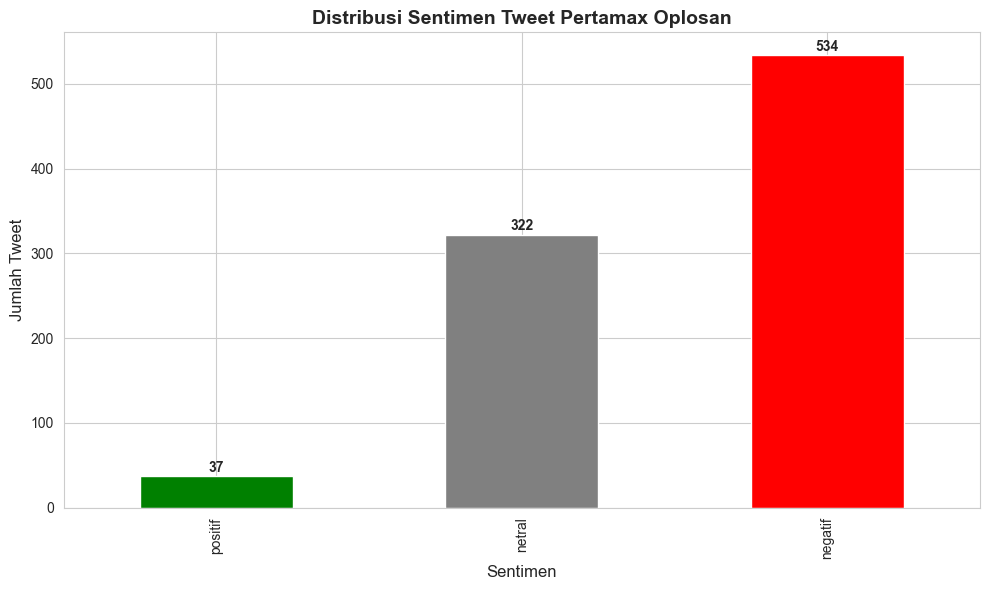

Membuat word cloud...


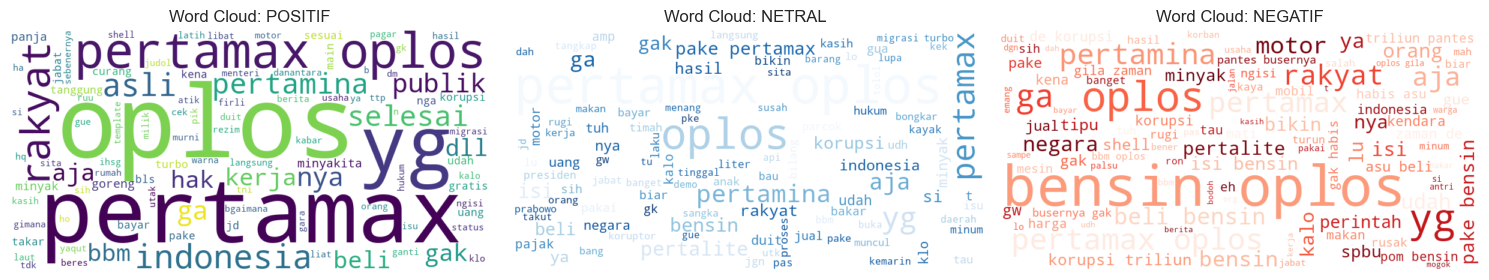

Menganalisis kata-kata pada sentimen negatif...


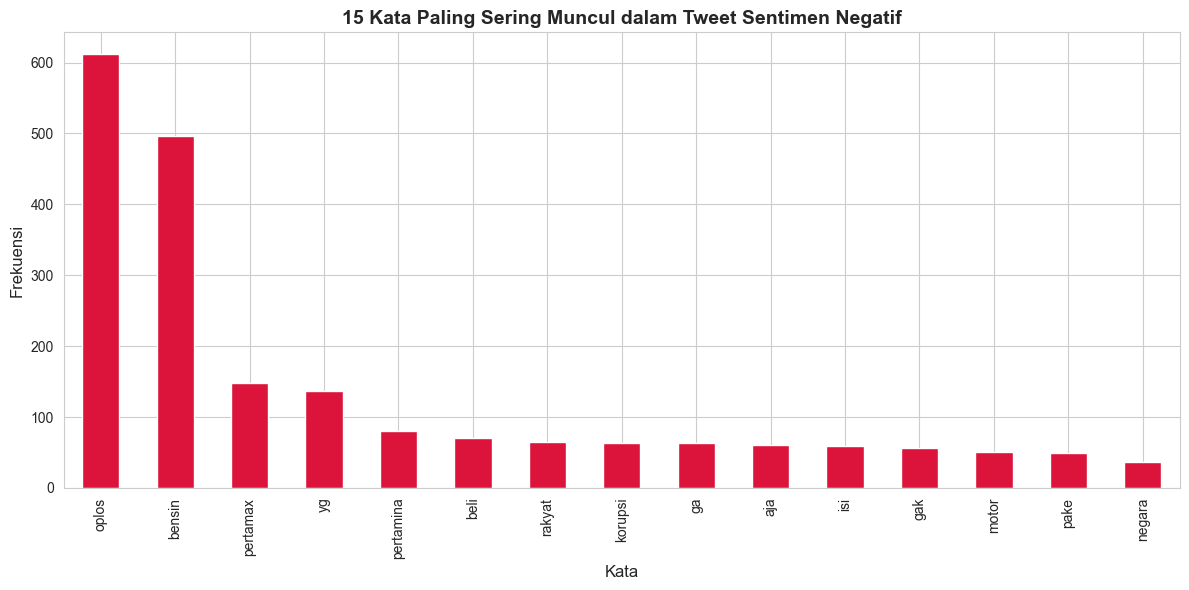

Menyimpan hasil analisis...

=========== RINGKASAN HASIL ANALISIS ===========
Total tweet: 893
Distribusi sentimen:
- positif: 37 tweet (4.1%)
- netral: 322 tweet (36.1%)
- negatif: 534 tweet (59.8%)

Contoh tweet dengan sentimen NEGATIF:
- @tanyakanrl Manipulasi bangettt btw nder kalau dia mati siram aja kuburannya pake pertamax oplosan...
- @CNNIndonesia Tetap waspada selalu mengingatkan dan mempertanyakan kepada @KejaksaanRI sudah sampai ...
- @pertamina pak pertamax oplosan udah nyebar ke luar pulau jawa. Banyak banget yg jadi korbannya nga ...

Contoh tweet dengan sentimen POSITIF:
- @nnaatnnatt iminas pakenya pertamax asli gapake yang oplosan SKYNANI BOOK FAIR FANSIGN #BKKIBF2025xS...
- @sukasukadh Astagfirullah memang memang kok : ) Gara gara oplosan itu aku skrng kalo ngisi pertamax ...
- @prophetofzorck Yup. Dr pd panjang urusan kasih duit aja beres...

Analisis selesai! Data disimpan di 'hasil_analisis_sentimen_custom.csv'


In [58]:
# 📦 Import Library yang Lebih Sederhana
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK resources (hanya perlu dijalankan sekali)
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    print("Gagal mengunduh vader_lexicon, tapi akan tetap melanjutkan...")

# Aktifkan tqdm untuk pandas
tqdm.pandas()

# 📂 Load Data
print("Membaca dataset...")
df = pd.read_csv("gabungan.csv")

# 🧹 1. CLEANING DATA
def clean_text(text):
    if isinstance(text, str):
        # Hapus mention (@username) dengan pattern yang lebih ketat
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        # Hapus URL dengan pattern yang lebih lengkap
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Hapus hashtag tetapi simpan katanya
        text = re.sub(r'#(\w+)', r'\1', text)
        # Hapus karakter khusus (emoji, tanda baca)
        text = re.sub(r'[^\w\s]', ' ', text)
        # Ubah ke lowercase
        text = text.lower()
        # Hapus angka
        text = re.sub(r'\d+', '', text)
        # Hapus spasi berlebih
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ""

print("Membersihkan teks...")
df['cleaned_text'] = df['full_text'].progress_apply(clean_text)

# 🌿 2. NORMALISASI (Stopword Removal & Stemming)
# Load stopword Indonesia
print("Memuat stopwords...")
try:
    with open('stopword.txt', 'r') as f:
        stopwords = f.read().splitlines()
except FileNotFoundError:
    print("File stopword.txt tidak ditemukan. Menggunakan list stopword default.")
    stopwords = ["yang", "dan", "di", "dengan", "untuk", "tidak", "ini", "dari", "dalam", "akan", "pada", "juga", "saya", "ke", "karena", "tersebut", "bisa", "ada", "mereka", "lebih", "kata", "tahun", "sudah", "atau", "saat", "oleh", "menjadi", "orang"]

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def normalize_text(text):
    if isinstance(text, str):
        # Hapus stopword
        words = text.split()
        words = [word for word in words if word not in stopwords]
        # Stemming
        text = ' '.join(words)
        text = stemmer.stem(text)
        return text
    return ""

print("Melakukan normalisasi teks...")
df['normalized_text'] = df['cleaned_text'].progress_apply(normalize_text)

# 😊😠 3. ANALISIS SENTIMEN DENGAN METODE HYBRID
print("Melakukan analisis sentimen...")

# Dictionary kata kunci untuk analisis sentimen bahasa Indonesia
kata_negatif = [
    'rusak', 'bohong', 'mesin', 'rusak', 'palsu', 'oplosan', 'bahaya', 'korban', 'buruk', 
    'jelek', 'protes', 'kecewa', 'mahal', 'menipu', 'gagal', 'penipuan', 'berbahaya', 
    'masalah', 'kerugian', 'rugi', 'boros', 'komplain', 'keluhan', 'hancur', 'bengkel',
    'perbaikan', 'knocking', 'getaran', 'mogok', 'konsumen', 'korban', 'salah', 'parah',
    'tertipu', 'turun', 'tuntutan', 'ganti', 'bensin', 'kampungan', 'murahan', 'bodoh',
    'sia', 'percuma', 'mati', 'terbakar', 'panas', 'asap', 'berasap', 'seret', 'lambat'
     , 'campuran', 'tidak asli', 'ditambah', 'kadaluarsa', 'tidak murni', 'bukan pertamax', 'oplosan', 'palsu', 'bahan campuran', 'bensin palsu', 'bensin campuran', 'campuran', 'keruh', 'tidak jernih', 'berlumpur', 'mengendap', 'menguning', 'bau aneh', 'berbau', 'gas berlebih', 'tidak standar', 'oktan turun'
     ,  'mesin rusak', 'mogok', 'knocking', 'piston jebol', 'busi mati', 'filter kotor', 'tarikan berat', 'tenaga hilang', 'boros parah', 'asap hitam', 'mesin ngelitik'
]

kata_positif = [
    'bagus', 'solusi', 'beres', 'teratasi', 'klarifikasi', 'perbaikan', 'tanggung', 'jawab',
    'ganti', 'rugi', 'kompensasi', 'bantuan', 'selesai', 'clear', 'baik', 'lancar', 'asli', 'murni', 'terjamin', 'standar', 'sesuai', 'uji lab', 'sertifikat', 'kualitas baik', 'irit', 'tenaga optimal', 'tarikan enteng', 'performanya bagus', 'tidak knocking', 'bersih', 'tidak meninggalkan residu', 'bensin aman'
]

# Fungsi untuk analisis sentimen berbasis kamus kata
def analyze_sentiment_custom(text):
    if not isinstance(text, str) or not text.strip():
        return "netral"
    
    # Split teks menjadi kata-kata
    words = text.lower().split()
    
    # Hitung kemunculan kata positif dan negatif
    count_negatif = sum(1 for kata in kata_negatif if kata in words)
    count_positif = sum(1 for kata in kata_positif if kata in words)
    
    # Tentukan sentimen berdasarkan perbandingan
    if count_negatif > count_positif:
        return "negatif"
    elif count_positif > count_negatif:
        return "positif"
    else:
        # Coba gunakan VADER sebagai fallback jika tersedia
        try:
            sid = SentimentIntensityAnalyzer()
            sentiment_scores = sid.polarity_scores(text)
            
            if sentiment_scores['compound'] >= 0.05:
                return "positif"
            elif sentiment_scores['compound'] <= -0.05:
                return "negatif"
            else:
                return "netral"
        except:
            # Jika VADER gagal, gunakan bias negatif untuk isu Pertamax Oplosan
            if any(word in words for word in ['pertamax', 'oplosan', 'bbm', 'premium']):
                return "negatif"
            else:
                return "netral"

# Analisis sentimen teks
print("Menganalisis sentimen...")
df['sentiment'] = df['normalized_text'].progress_apply(analyze_sentiment_custom)

# 📊 4. VISUALISASI
# Distribusi Sentimen
print("Membuat visualisasi sentimen...")
plt.figure(figsize=(10, 6))
colors = {'negatif': 'red', 'netral': 'gray', 'positif': 'green'}
sentiment_counts = df['sentiment'].value_counts()

# Pastikan semua kategori muncul
for sentiment in ['negatif', 'netral', 'positif']:
    if sentiment not in sentiment_counts:
        sentiment_counts[sentiment] = 0

# Urutkan untuk konsistensi
sentiment_counts = sentiment_counts.reindex(['positif', 'netral', 'negatif'])
bars = sentiment_counts.plot(kind='bar', color=[colors[x] for x in sentiment_counts.index])

# Tambahkan label di atas bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.title("Distribusi Sentimen Tweet Pertamax Oplosan", fontsize=14, fontweight='bold')
plt.xlabel("Sentimen", fontsize=12)
plt.ylabel("Jumlah Tweet", fontsize=12)
plt.tight_layout()
plt.savefig('distribusi_sentimen.png', dpi=300)
plt.show()

# Word Cloud berdasarkan sentimen
print("Membuat word cloud...")

# Membuat word cloud untuk setiap sentimen
sentiments = ['positif', 'netral', 'negatif']
plt.figure(figsize=(15, 10))

for i, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['sentiment'] == sentiment]['normalized_text'].dropna())
    if text.strip():
        plt.subplot(1, 3, i+1)
        wordcloud = WordCloud(width=800, height=400, 
                              background_color='white', 
                              max_words=100,
                              colormap='viridis' if sentiment == 'positif' else
                                       'Blues' if sentiment == 'netral' else 'Reds').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud: {sentiment.upper()}")

plt.tight_layout()
plt.savefig('wordcloud_by_sentiment.png', dpi=300)
plt.show()

# Analisis tambahan: kata yang paling sering muncul pada sentimen negatif
print("Menganalisis kata-kata pada sentimen negatif...")
if len(df[df['sentiment'] == 'negatif']) > 0:
    negative_words = ' '.join(df[df['sentiment'] == 'negatif']['normalized_text'].dropna()).split()
    word_freq = pd.Series(negative_words).value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    word_freq.plot(kind='bar', color='crimson')
    plt.title("15 Kata Paling Sering Muncul dalam Tweet Sentimen Negatif", fontsize=14, fontweight='bold')
    plt.xlabel("Kata", fontsize=12)
    plt.ylabel("Frekuensi", fontsize=12)
    plt.tight_layout()
    plt.savefig('negative_word_frequency.png', dpi=300)
    plt.show()

# 💾 Save Hasil ke CSV
print("Menyimpan hasil analisis...")
df.to_csv("hasil_analisis_sentimen_custom.csv", index=False)

# Tampilkan statistik hasil
print("\n=========== RINGKASAN HASIL ANALISIS ===========")
print(f"Total tweet: {len(df)}")
print("Distribusi sentimen:")
for sentiment, count in sentiment_counts.items():
    print(f"- {sentiment}: {count} tweet ({count/len(df)*100:.1f}%)")

# Cetak beberapa contoh dari setiap kategori
print("\nContoh tweet dengan sentimen NEGATIF:")
for _, row in df[df['sentiment'] == 'negatif'].head(3).iterrows():
    print(f"- {row['full_text'][:100]}...")

print("\nContoh tweet dengan sentimen POSITIF:")
for _, row in df[df['sentiment'] == 'positif'].head(3).iterrows():
    print(f"- {row['full_text'][:100]}...")

print("\nAnalisis selesai! Data disimpan di 'hasil_analisis_sentimen_custom.csv'")